# Загрузка

In [1]:
target = ['t˚ C трубы после спреера']

In [125]:
ls_columns_output = [
#     '№ партии',
#     '№ плавки',
    'марка стали',
    'диаметр',
    'толщина стенки',
    'Гр. прочн.',
    '1 зона по ВТР закалка',
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка',
    'шаг балок закалочная печь, сек',
    'Скорость прохождения трубы через спрейер, м/с', 
    '1 зона ВТР и уставка отпуск', 
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск',
    'шаг балок отпускная печь, сек',
    'C',
    'Mn',
    'Si',
    'P',
    'S',
    'Cr',
    'Ni',
    'Cu',
    'Al',
    'V',
    'Ti',
    'Nb',
    'Mo',
    'N',
    'B',
    'C-coef',
    'Параметр закалка',
    'Параметр отпуск',
    'Параметр отпуск новый V',
    'Величина зерна',
    'Тип предела текучести (1186)',
#     'Дата термообработки',
    'ICD',
#     'Примечание',
    'длина трубы'
    ]

In [37]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random
from datetime import datetime

In [38]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
from sklearn import model_selection
import matplotlib.pyplot as plt
import os
from time import time
from datetime import datetime
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr

In [201]:
df = pd.read_csv('DATA/prepared/prepared_to_saw_gp.csv', low_memory=False)

In [202]:
df['№ плавки'] = df['№ плавки'].astype(str)
df['№ плавки'] = df['№ плавки'].apply(lambda x: x.lower())
df['№ партии'] = df['№ партии'].astype(str)

In [203]:
df_ = df.copy()
df_.shape

(24503, 201)

In [204]:
def bath2spr(df):
    L = 8.4
    df['Скорость прохождения трубы через спрейер, м/с'] = L/df['время выдержки в закалочной ванне, сек.']
    df['t˚ C трубы после спреера'] = df['t˚ C трубы после ванны']
    return df

In [205]:
bath = df_[~df_['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_ = df_[df_['время выдержки в закалочной ванне, сек.'].isnull()].copy()


bath = bath2spr(bath)

df = pd.concat([df_, bath])
df.reset_index(inplace=True, drop=True)

In [206]:
df.shape

(24503, 201)

In [207]:
df = len_pipe(df)

df = mean_chem(df)

df = calc_all_features(df)

In [208]:
df = df[df['шаг балок закалочная печь, сек'] < 100]
df = df[df['шаг балок закалочная печь, сек'] >= 24]
df = df[df['шаг балок отпускная печь, сек'] >= 24]
df = df[df['Скорость прохождения трубы через спрейер, м/с'] <= 1]
df = df[df['t˚ C трубы после спреера'] > 1]
df = df[df['t˚ C трубы после спреера'] <= 250]
df = df[df['2 зона ВТР и уставка отпуск'] > 400]
df = df[df['4 зона ВТР и уставка отпуск'] > 400]

In [209]:
df.shape

(23716, 202)

In [210]:
df['Дата термообработки'] = df['Дата термообработки'].apply(lambda x: str(x).replace(' 00:00:00', ''))
df['Дата термообработки'] = df['Дата термообработки'].apply(lambda x: str(x).replace('-', '.'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000005C97550>]],
      dtype=object)

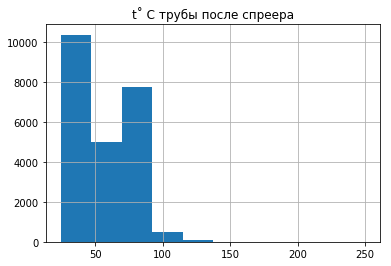

In [211]:
df[target].hist()

In [212]:
df[target].describe()

,t˚ C трубы после спреера
count,23716.000000
mean,56.295364
std,17.523852
min,24.600000
25%,41.333333
50%,52.500000
75%,70.000000
max,250.000000


In [213]:
tmp = []
for x in df['Дата термообработки']:
    try:
        tmp.append(datetime.strptime(x, "%d.%m.%Y"))
    except ValueError:
        tmp.append(datetime.strptime(x, "%Y.%m.%d"))
df['Дата термообработки'] = tmp

In [214]:
df[ls_columns_output+list(target)].dropna().shape

(23314, 39)

In [230]:
ls_train = ls_columns_output.copy()
# ls_train.remove('Дата термообработки')
ls_train.remove('марка стали')
ls_train.remove('Гр. прочн.')

for s in ls_to_del:
    ls_train.remove(s)

In [231]:
df = df[ls_train+list(target)].dropna()
df.drop_duplicates(inplace=True)

X, X_valid, y, y_valid = train_test_split(df[ls_train], df[target], test_size=0.2, shuffle=True)

In [243]:
X.shape, X_valid.shape

((13556, 30), (3390, 30))

In [244]:
X.columns

Index(['диаметр', 'толщина стенки', '1 зона по ВТР закалка',
       '2 зона по ВТР закалка', '3 зона по ВТР закалка',
       'шаг балок закалочная печь, сек',
       'Скорость прохождения трубы через спрейер, м/с',
       '1 зона ВТР и уставка отпуск', '2 зона ВТР и уставка отпуск',
       '3 зона ВТР и уставка отпуск', '4 зона ВТР и уставка отпуск',
       '5 зона ВТР и уставка отпуск', 'шаг балок отпускная печь, сек', 'C',
       'Mn', 'Si', 'Cr', 'Ni', 'Cu', 'V', 'Ti', 'Nb', 'Mo', 'N',
       'Параметр закалка', 'Параметр отпуск', 'Параметр отпуск новый V',
       'Величина зерна', 'ICD', 'длина трубы'],
      dtype='object')

In [245]:
def print_and_return_score(x, y, est, verb=1):
    y_pred = est.predict(x)
#     scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    corr = np.corrcoef(y.T, y_pred)
    
    if verb==1:        
        print('R^2: ', round(r2, 2))
        print('MAE: ', round(mae, 2))
        print('MSE: ', round(mse, 2))
        print('Correlation1: ', round(corr[0][1], 2))
    return [mae, mse, corr[0][1]]

In [246]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [247]:
len(ls_train)

30

In [248]:
# с удаленными незначимыми столбцами
rfc = RandomForestRegressor(max_features = 13, max_depth = 18, min_samples_leaf = 1, n_estimators=50, criterion='mse')
rfc.fit(X_train, y_train)

mae, mse, corr1 = print_and_return_score(X_test, y_test, rfc)

D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


R^2:  0.95
MAE:  2.0
MSE:  15.7
Correlation1:  0.97


In [249]:
X_valid.shape, X_test.shape

((3390, 30), (2712, 30))

In [250]:
pd.merge(X_test, X_valid, how='inner').shape

(217, 30)

In [251]:
mae, mse, corr1 = print_and_return_score(X_valid, y_valid, rfc)

R^2:  0.95
MAE:  2.06
MSE:  16.68
Correlation1:  0.97


In [252]:
val = rfc.feature_importances_
lab = ls_train
dict_feat_import = dict(zip(lab, val))
ls_to_del = []
for feat, imp in zip(lab, val):
    print(feat, '  ', imp.round(2))
    if imp.round(2) < 0.01:
        ls_to_del.append(feat)

диаметр    0.05
толщина стенки    0.08
1 зона по ВТР закалка    0.02
2 зона по ВТР закалка    0.02
3 зона по ВТР закалка    0.04
шаг балок закалочная печь, сек    0.07
Скорость прохождения трубы через спрейер, м/с    0.1
1 зона ВТР и уставка отпуск    0.01
2 зона ВТР и уставка отпуск    0.02
3 зона ВТР и уставка отпуск    0.0
4 зона ВТР и уставка отпуск    0.03
5 зона ВТР и уставка отпуск    0.0
шаг балок отпускная печь, сек    0.17
C    0.01
Mn    0.01
Si    0.01
Cr    0.01
Ni    0.01
Cu    0.01
V    0.01
Ti    0.01
Nb    0.05
Mo    0.02
N    0.01
Параметр закалка    0.11
Параметр отпуск    0.01
Параметр отпуск новый V    0.01
Величина зерна    0.01
ICD    0.01
длина трубы    0.11


In [253]:
ls_to_del

['3 зона ВТР и уставка отпуск', '5 зона ВТР и уставка отпуск']

## GridSearchCV

In [254]:
param_grid = {
    'max_depth': range(10, 18, 2),
    'max_features': range(10, 18, 2),
    'min_samples_leaf': range(1, 4),
    'n_estimators': range(50, 300, 50)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [256]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 17.0min finished
D:\Repo\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 18, 2), 'max_features': range(10, 18, 2), 'min_samples_leaf': range(1, 4), 'n_estimators': range(50, 300, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [257]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 14,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [261]:
mae, mse, corr = print_and_return_score(X_test, y_test, grid_search)

R^2:  0.95
MAE:  2.13
MSE:  16.58
Correlation1:  0.97


In [262]:
y_predict = grid_search.predict(X_test)

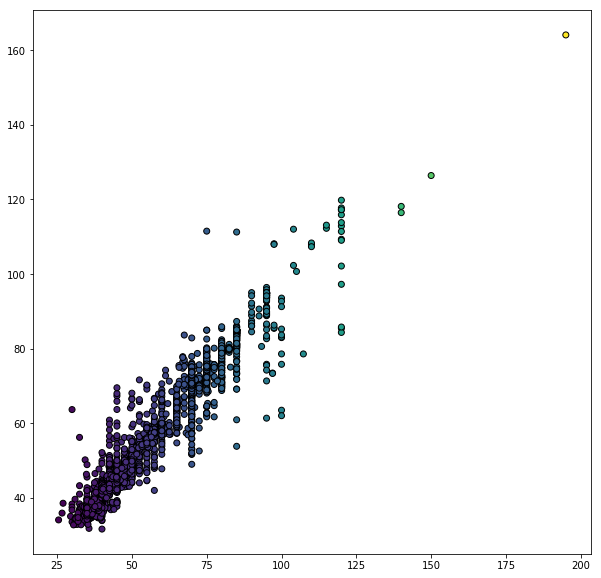

In [263]:
plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_predict, marker='o', c=y_test, edgecolors='black', cmap='viridis')
# plt.colorbar()
plt.show()

## Cross-validation with KFold

In [264]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kfold.split(X, y):
    x_train, y_train = X.iloc[train], y.iloc[train]
    x_test, y_test = X.iloc[test], y.iloc[test]
    grf = grid_search.best_estimator_
    grf.fit(x_train, y_train)

    scores.append(print_and_return_score(X_valid, y_valid, grf))

D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


R^2:  0.95
MAE:  2.04
MSE:  16.53
Correlation1:  0.97


D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


R^2:  0.94
MAE:  2.06
MSE:  17.92
Correlation1:  0.97


D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


R^2:  0.95
MAE:  2.06
MSE:  17.25
Correlation1:  0.97


D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


R^2:  0.96
MAE:  2.01
MSE:  13.21
Correlation1:  0.98


D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


R^2:  0.95
MAE:  2.06
MSE:  17.05
Correlation1:  0.97


In [270]:
for i in range(3):
    tmp = []
    for j in range(3):
        tmp.append(scores[j][i])
    print(round(np.mean(tmp), 2))

2.05
17.24
0.97


In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
grf = grid_search.best_estimator_
grf.fit(X_train, y_train)
mae, mse, corr1 = print_and_return_score(X_test, y_test, grf)

D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


R^2:  0.95
MAE:  2.13
MSE:  15.38
Correlation1:  0.97


In [290]:
''' Проверка на 147 строчках ванны '''
# bath_valid_ = bath_valid.dropna() 
# X_valid = bath_valid_[ls_train_col]
# y_valid = bath_valid_[targets]

In [305]:
X_valid.shape

(1466, 37)

In [279]:
y_pred = pd.DataFrame(rfc.predict(X_valid), columns=['прогноз t˚ C трубы после спреера'])
y_pred.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

mae, mse, corr1 = print_and_return_score(X_valid, y_valid, rfc)
scr = r2_score(y_valid, y_pred)

score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation':[corr1],}),
                      y_pred,
                      y_valid],
                    axis=1)

score_df['MAE'] = np.abs(score_df['t˚ C трубы после спреера'] - score_df['прогноз t˚ C трубы после спреера'])

R^2:  0.95
MAE:  2.06
MSE:  16.68
Correlation1:  0.97


In [278]:
y_pred = pd.DataFrame(grf.predict(X_valid), columns=['прогноз t˚ C трубы после спреера'])
y_pred.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

mae, mse, corr1 = print_and_return_score(X_valid, y_valid, grf)
scr = r2_score(y_valid, y_pred)

score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation':[corr1],
                                                     }),
                      y_pred,
                      y_valid],
                    axis=1)

score_df['MAE'] = np.abs(score_df['t˚ C трубы после спреера'] - score_df['прогноз t˚ C трубы после спреера'])

R^2:  0.94
MAE:  2.11
MSE:  18.12
Correlation1:  0.97


In [281]:
save_RF_model(rfc, ls_train, 'temp pipe after spr', score_df)

Модель сохранена
